## Running the Fast & Fusiest Mapper (FFM)
This notebook shows how to run the Fast & Fuseiest Mapper (FFM) on a full workload and
architecture.

In [1]:
# Imports
import fastfusion as ff
from IPython.display import SVG, display
import os
ff.set_n_parallel_jobs(os.cpu_count(), print_message=True)

Using 32 parallel jobs


WARNING Loading configuration file from /root/.config/fastfusion/config.yaml


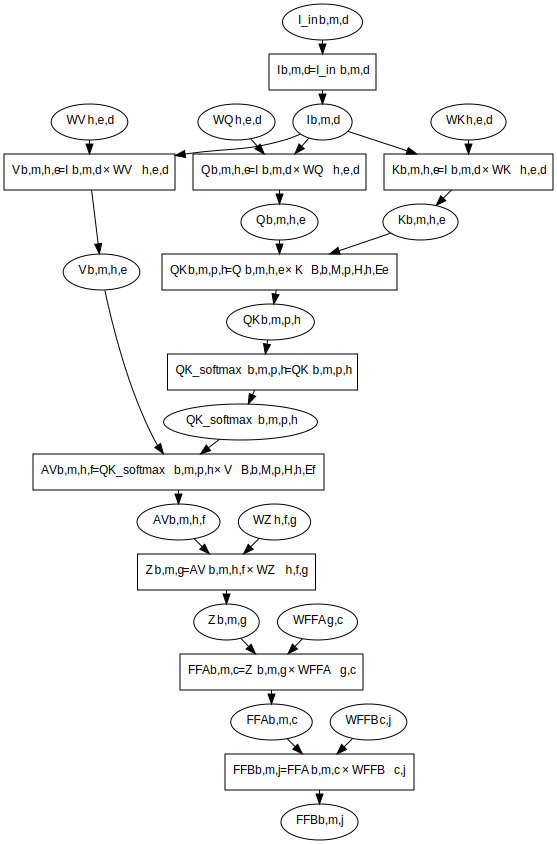

In [2]:
# Initialize the specification and show the workload.
BATCH_SIZE = 1
N_TOKENS = 16384
FUSE = True

spec = ff.Spec.from_yaml(
    # "arch/tpu_v4i_like.yaml",
    "arch/simple.arch.yaml",
    "workload/gpt3_6.7B.yaml",
    jinja_parse_data=dict(
        BATCH_SIZE=BATCH_SIZE,
        N_TOKENS=N_TOKENS,
    )
)

# If fusion is disabled, keep all tensors in main memory.
if not FUSE:
    spec.arch.nodes["MainMemory"].constraints.tensors.keep = "All()"

display(SVG(spec.workload.render()))

In [3]:
# Generate the pmappings.

# Set optimization metrics
spec.mapper.ffm.metrics = ff.mapper.FFM.Metrics.ENERGY
# spec.mapper.ffm.metrics = ff.mapper.FFM.Metrics.ENERGY

pmappings = ff.mapper.FFM.make_pmappings(
    spec,
    # Having can_combine_multiple_runs=False enables some optimizations, but prevents
    # you from doing things like:
    #   pmappings = make_pmappings(*args_a) | make_pmappings(*args_b)
    can_combine_multiple_runs=False,
)

Generating jobs:   0%|          | 0/10 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum I: 3it [00:00, 29.97it/s]]]/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 8it [00:00, 57.87it/s]
Generating pmapping templates for compute MAC Einsum FFB: 12it [00:00, 52.52it/s]
Generating pmapping templates for compute MAC Einsum V: 24it [00:00, 79.96it/s]]
Generating pmapping templates for compute MAC Einsum K: 24it [00:00, 77.98it/s]]]
Generating pmapping templates for compute MAC Einsum Z: 24it [00:00, 70.83it/s]
Generating pmapping templates for compute MAC Einsum Q: 24it [00:00, 72.58it/s]]
Generating pmapping templates for compute MAC Einsum FFA: 24it [00:00, 70.09it/s]
Generating pmapping templates for compute MAC Einsum QK: 48it [00:00, 82.63it/s]
Generating pmapping templates for compute MAC Einsum AV: 48it [00:00, 84.88it/s]
Generating jobs: 100%|██████████| 10/10 [00:02<00:00,  4.95it/s]
WARNING Einsum I has 3 pmapping templates:
WARNING 	[I_in in MainMemory] T-b,d,m initial=symbol stride=symbol [I 

In [4]:
# Output some stats about the generated pmappings.
print(f"Total number of pmappings: {pmappings.total_pmappings()}")
print(f"Number of valid pmappings: {pmappings.valid_pmappings()}")
print(f"Number of Pareto-optimal pmappings: {pmappings.pareto_optimal_pmappings()}")
print(f"Number of evaluated pmappings: {pmappings.evaluated_pmappings()}")

Total number of pmappings: 6867906.437765951
Number of valid pmappings: 465967.0
Number of Pareto-optimal pmappings: 328217
Number of evaluated pmappings: 1615099


In [5]:
# Join the pmappings to create a full mapping.
mappings = ff.mapper.FFM.join_pmappings(
    spec,
    pmappings,
)

Einsum I has 196 pmappings with 5 compatibilities
Einsum V has 27400 pmappings with 181 compatibilities
Einsum K has 27400 pmappings with 181 compatibilities
Einsum Q has 27400 pmappings with 181 compatibilities
Einsum QK has 96942 pmappings with 391 compatibilities
Einsum QK_softmax has 12701 pmappings with 43 compatibilities
Einsum AV has 96942 pmappings with 391 compatibilities
Einsum Z has 27400 pmappings with 181 compatibilities
Einsum FFA has 8222 pmappings with 71 compatibilities
Einsum FFB has 3614 pmappings with 28 compatibilities


Compressing pmappings: 100%|██████████| 10/10 [00:01<00:00,  7.54it/s]


Not tracking MainMemory because its size 9999999999999 is enough for the sum of all reservations (26776436736)


Merging pmappings for FFA <--> FFB (10/10): 100%|██████████| 69/69 [00:01<00:00, 34.80it/s]


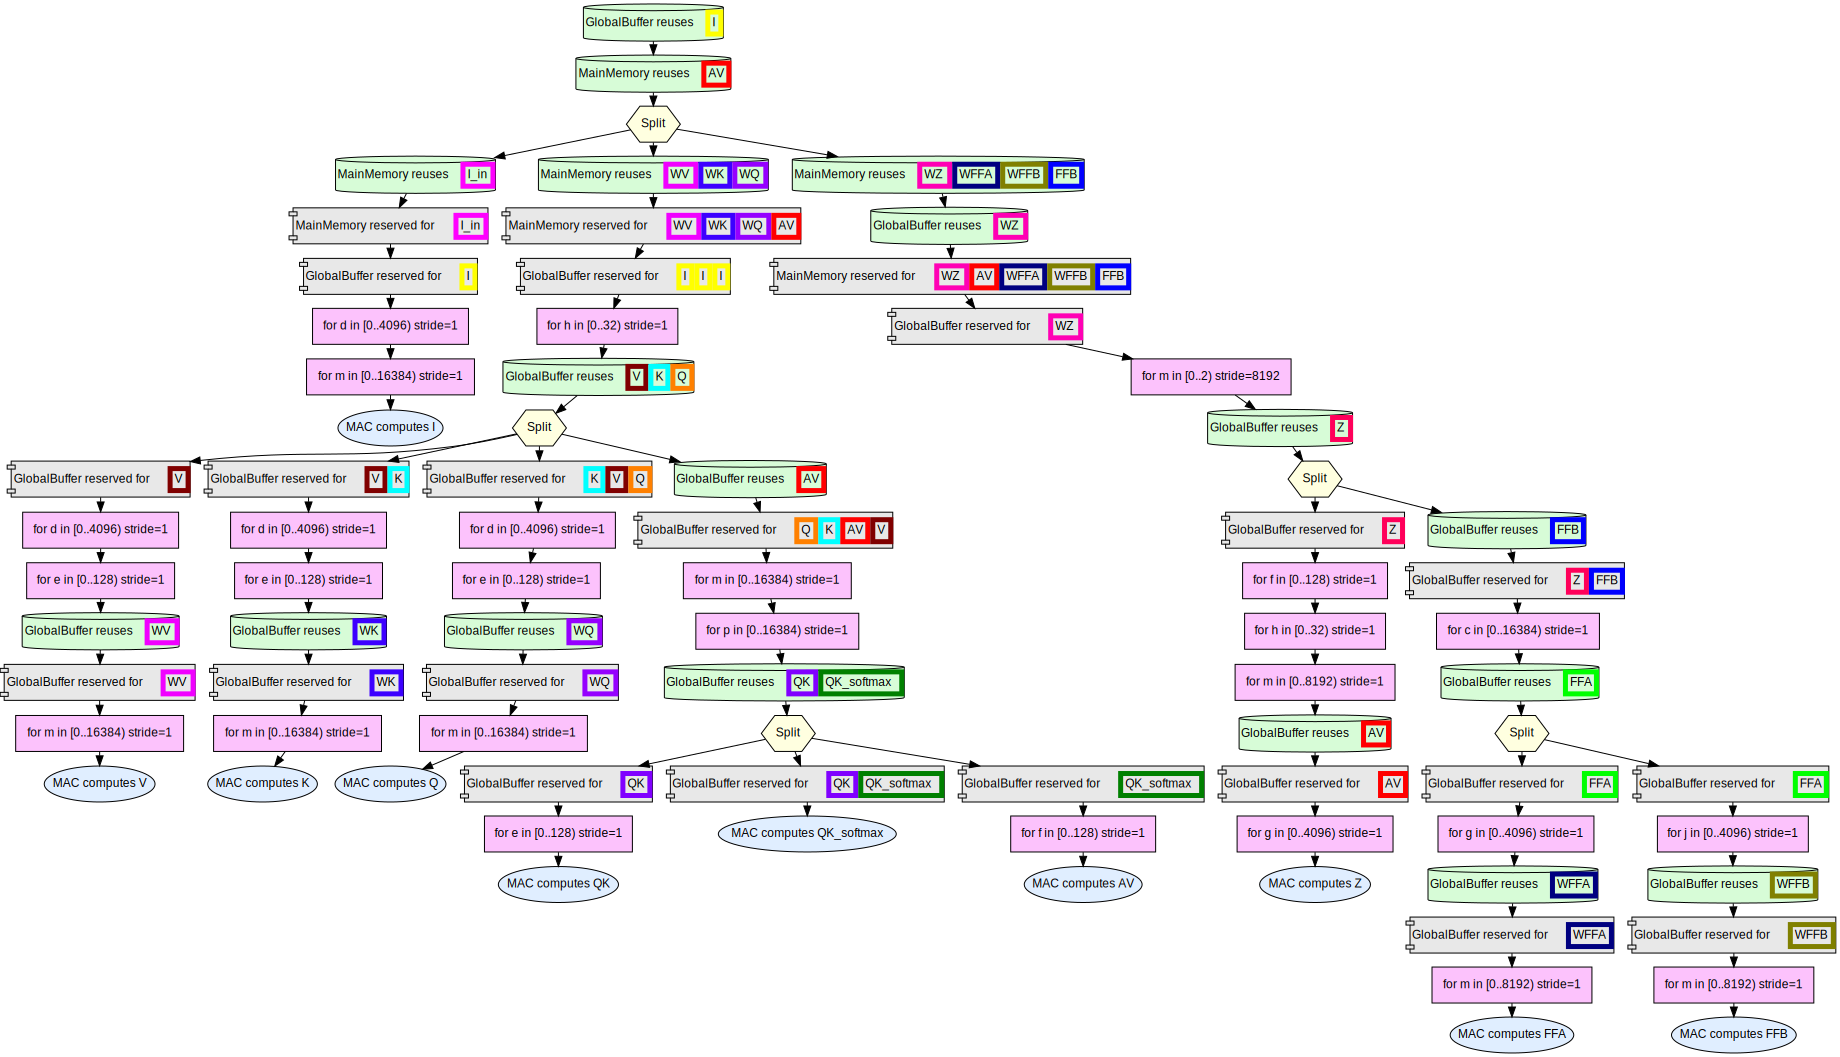

Totals:
	energy: 603979776.0
	mapping: <fastfusion.mapper.FFM._interface.main.MappingFromRow object at 0x7f9eb5716000>
Per-compute energy: 0.00010969055076844325
Individual latencies:
	Total: 603979776.0
	I<SEP>GlobalBuffer<SEP>read: 0
	I<SEP>GlobalBuffer<SEP>write: 0
	I<SEP>MainMemory<SEP>read: 67108864.0
	I<SEP>MainMemory<SEP>write: 0
	I<SEP>MAC<SEP>compute: 0
	I<SEP>MainMemory<SEP>leak: 0
	I<SEP>GlobalBuffer<SEP>leak: 0
	I<SEP>MAC<SEP>leak: 0
	V<SEP>GlobalBuffer<SEP>read: 0
	V<SEP>GlobalBuffer<SEP>write: 0
	V<SEP>MainMemory<SEP>read: 16777216.0
	V<SEP>MainMemory<SEP>write: 0
	V<SEP>MAC<SEP>compute: 0
	V<SEP>MainMemory<SEP>leak: 0
	V<SEP>GlobalBuffer<SEP>leak: 0
	V<SEP>MAC<SEP>leak: 0
	K<SEP>GlobalBuffer<SEP>read: 0
	K<SEP>GlobalBuffer<SEP>write: 0
	K<SEP>MainMemory<SEP>read: 16777216.0
	K<SEP>MainMemory<SEP>write: 0
	K<SEP>MAC<SEP>compute: 0
	K<SEP>MainMemory<SEP>leak: 0
	K<SEP>GlobalBuffer<SEP>leak: 0
	K<SEP>MAC<SEP>leak: 0
	Q<SEP>GlobalBuffer<SEP>read: 0
	Q<SEP>GlobalBuffer<SEP>wr

In [6]:
# The joined pmappings object contains a DataFrame of all Pareto-optimal pmappings for
# the given optimization metrics. Since we're only interested in one metric, this should
# have exaclty one row, but we'll grab index 0 to be sure.
mappings = mappings[0]

# Show the mapping.
display(SVG(mappings.render()))

# All units are SI units-- seconds, joules, meters, etc.
print(f"Totals:")
for k, v in mappings.access("Total").to_dict().items():
    print(f"\t{k}: {v}")

accessor = "latency" if spec.mapper.ffm.metrics == ff.mapper.FFM.Metrics.LATENCY else "energy"
per_compute = mappings.access("Total").per_compute().to_dict()[accessor]
print(f'Per-compute {accessor}: {per_compute}')

print(f'Individual latencies:')
for k, v in mappings.access(accessor).to_dict().items():
    print(f"\t{k}: {v}")

In [7]:
# Print the other stats
for k, v in mappings.to_dict().items():
    print(f"{k}: {v}")

tensor<SEP>I: 67108864
Total<SEP>energy: 603979776.0
tensor<SEP>V: 2097152
tensor<SEP>K: 2097152
tensor<SEP>Q: 2097152
tensor<SEP>QK: 1
tensor<SEP>QK_softmax: 1
tensor<SEP>AV: 67108864
tensor<SEP>Z: 33554432
tensor<SEP>FFA: 8192
I<SEP>stride0: 1
I<SEP>stride1: 4096
I<SEP>stride2: 16384
I<SEP>energy<SEP>GlobalBuffer<SEP>read: 0
I<SEP>energy<SEP>GlobalBuffer<SEP>write: 0
I<SEP>energy<SEP>MainMemory<SEP>read: 67108864.0
I<SEP>energy<SEP>MainMemory<SEP>write: 0
I<SEP>energy<SEP>MAC<SEP>compute: 0
I<SEP>energy<SEP>MainMemory<SEP>leak: 0
I<SEP>energy<SEP>GlobalBuffer<SEP>leak: 0
I<SEP>energy<SEP>MAC<SEP>leak: 0
I<SEP>n_iterations0: 1.0
I<SEP>n_iterations1: 1.0
I<SEP>n_iterations2: 1.0
I<SEP>mapping: type=None nodes=[Storage(type=None, tensors=['I_in'], component='MainMemory', component_object=Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, global_cycle_period=1e-09, n_instances=1, energy_scale=1, area_scale=1, energy=None, area=None, datawidth={'All()': 1}, bandwi